In [1]:
%pip install openai-clip

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Food-101 Benchmark

In [2]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [3]:

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

train_dataset = datasets.Food101(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.Food101(root='./data', split='test', download=True)

print(len(train_dataset))
print(len(test_dataset))

trainloader = DataLoader(train_dataset, batch_size=96, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=96, shuffle=True)


75750
25250


### some sample from dataset

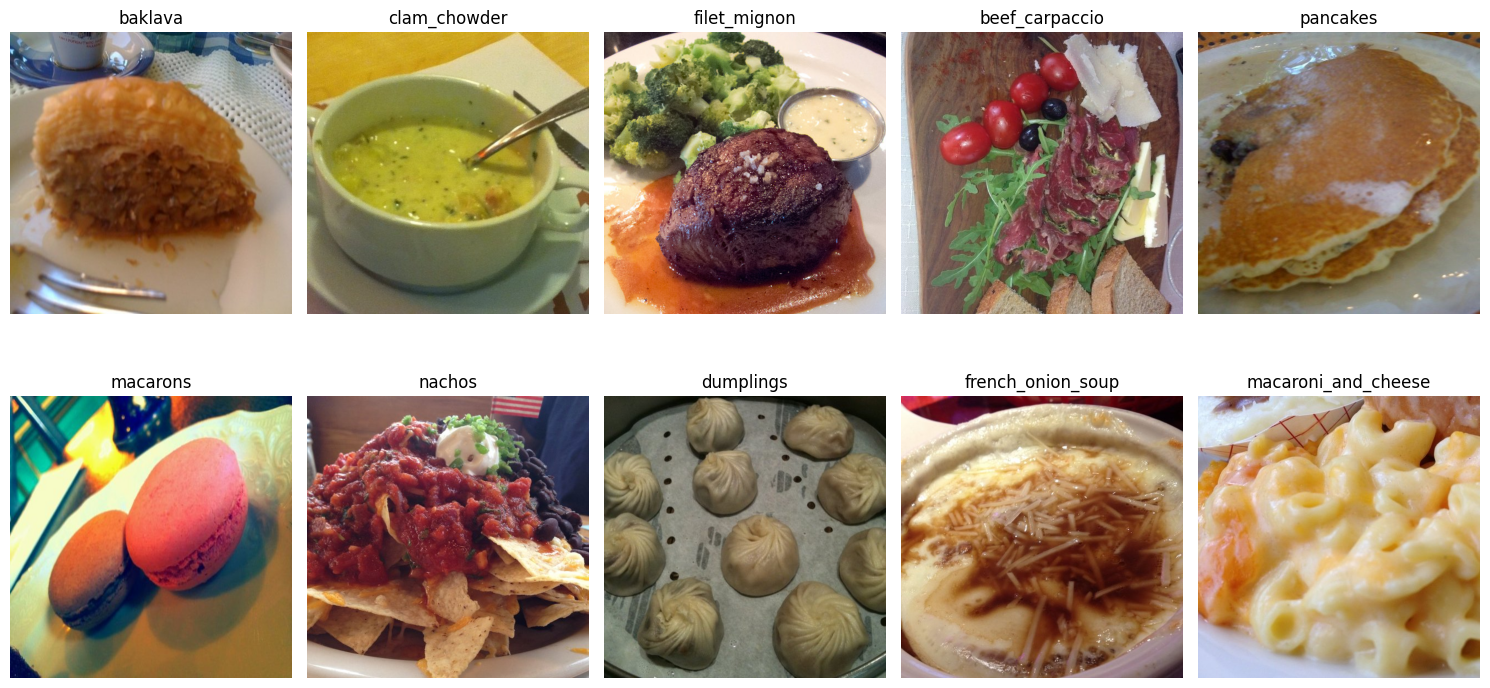

In [4]:

# Get 10 random samples from train dataset
figure = plt.figure(figsize=(15, 8))
for i in range(10):
    # Get a random index
    idx = np.random.randint(0, len(train_dataset))
    image, label = train_dataset[idx]
    
    # Add subplot
    plt.subplot(2, 5, i + 1)
    # Convert tensor to numpy array and transpose dimensions for display
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(train_dataset.classes[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


### CNN food 101

In [5]:
class LightCNN(nn.Module):
    def __init__(self):
        super(LightCNN, self).__init__()
        self.net = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fifth block
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Flatten and fully connected layers
            nn.Flatten(),
            nn.Linear(65536, 512),  # 256x256经过5次下采样后变为8x8
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 101)
        )

    def forward(self, x):
        x = self.net(x)
        return x
    
model = LightCNN()


In [6]:
loss_function = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    from tqdm import tqdm
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        train_pbar = tqdm(train_loader, desc='Training')
        for images, labels in train_pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        test_pbar = tqdm(test_loader, desc='Validating')
        with torch.no_grad():
            for images, labels in test_pbar:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print('--------------------')
        
    return train_losses, test_losses, train_accs, test_accs

In [8]:
# Train the model
num_epochs = 8
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses, train_accs, test_accs = train_model(model, trainloader, testloader, loss_function, optimizer, num_epochs, device)

print("Training completed!")

Epoch [1/8]


Training:   0%|          | 3/790 [01:17<5:40:58, 26.00s/it]


KeyboardInterrupt: 

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()